In [4]:
import datetime
from datetime import datetime
import pandas as pd
import sqlalchemy as sa
from meteostat import Point, Daily
import missingno as msno
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [5]:
class DatabaseConnection:

    def __init__(
        self,
        username: str,
        password: str,
        database: str = "sandbox",
        host: str = "database-1.cjyy8w6ya3fr.eu-north-1.rds.amazonaws.com",
        port: int = 3306,
        dialect: str = "mysql",
        driver: str = "pymysql",
    ) -> None:
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def reconnect(self):
        self.engine.dispose()
        self.engine = sa.create_engine(self.engine.url)

    def insert_dataframe(self, df: pd.DataFrame, table_name: str, dtype=None) -> None:
        try:
            with self.engine.begin() as conn:
                df.to_sql(table_name, con=conn, if_exists="replace", index=False, dtype=dtype)
        except Exception as e:
            print(f"Error inserting dataframe: {e}")
            self.reconnect()
            raise

    def query_to_df(self, query: str) -> pd.DataFrame:
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df

    def check_connection(self) -> bool:
        try:
            with self.engine.connect() as conn:
                conn.execute(sa.text("SELECT 1"))
            return True
        except Exception as e:
            print(f"Connection check failed: {e}")
            return False

def generate_sqlalchemy_dtypes(df: pd.DataFrame) -> dict:
    dtype_map = {}
    for col, dtype in df.dtypes.items():
        if pd.api.types.is_float_dtype(dtype):
            dtype_map[col] = DECIMAL(12, 2)
        elif pd.api.types.is_integer_dtype(dtype):
            dtype_map[col] = Integer()
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            dtype_map[col] = DateTime()
        elif pd.api.types.is_string_dtype(dtype):
            dtype_map[col] = String(255)
    return dtype_map

In [7]:
# Creamos la conexión con la base de datos usando usuario y contraseña
database = DatabaseConnection(DB_USERNAME, DB_PASSWORD)

# Verificamos si la conexión está activa
# Devuelve True si la base responde, False si hay algún problema
database.check_connection()


True

In [8]:
# Leemos los archivos Excel y los cargamos en DataFrames de pandas
df_ventas = pd.read_excel("/workspaces/Datathon/archivos/ArticulosPanaderia.xlsx")
df_calendario = pd.read_excel("/workspaces/Datathon/archivos/Calendario.xlsx")
df_pedidos = pd.read_excel("/workspaces/Datathon/archivos/CantidadPedida.xlsx")

# Subimos los DataFrames a la base de datos usando SQLAlchemy
# if_exists="replace" significa que si la tabla ya existe, se reemplaza
df_ventas.to_sql("ac_raw_ventas", con=database.engine, if_exists="replace", index=False)
df_calendario.to_sql("ac_raw_calendario", con=database.engine, if_exists="replace", index=False)
df_pedidos.to_sql("ac_raw_pedidos", con=database.engine, if_exists="replace", index=False)


107905

In [9]:
# Definimos una lista de consultas SQL que se ejecutarán secuencialmente
consulta = [
    # Bloque 1: Artículos top por familia
    """
    DROP TABLE IF EXISTS sandbox.ac_articulos_top;
    """,
    """
    CREATE TABLE sandbox.ac_articulos_top AS
    SELECT
        Articulo,
        FAMILIA,
        SUM(importe) AS importe_total,
        ROW_NUMBER() OVER (PARTITION BY FAMILIA ORDER BY SUM(importe) DESC) AS orden
    FROM sandbox.ac_raw_ventas
    WHERE FechaVenta >= '2021-05-01'
    GROUP BY Articulo, FAMILIA;
    """,

    # Bloque 2: Calendario de días (tabla con todas las fechas)
    """
    DROP TABLE IF EXISTS sandbox.ac_calendario_dias;
    """,
    """
    SET @@cte_max_recursion_depth = 4000;
    """,
    """
    CREATE TABLE sandbox.ac_calendario_dias AS
    WITH RECURSIVE cte_ac_calendario AS (
        SELECT DATE('2017-01-01') AS calendar_date
        UNION ALL
        SELECT DATE_ADD(calendar_date, INTERVAL 1 DAY) AS calendar_date
        FROM cte_ac_calendario
        WHERE DATE_ADD(calendar_date, INTERVAL 1 DAY) <= DATE('2023-12-31')
    )
    SELECT
        calendar_date AS fecha,
        YEAR(calendar_date) AS fx_anno,
        MONTH(calendar_date) AS fx_mes,
        DAY(calendar_date) AS fx_day,
        DATE_FORMAT(calendar_date, '%Y%m') AS fx_anno_mes,
        DATE_FORMAT(calendar_date, '%x-%v') AS semana
    FROM cte_ac_calendario;
    """,

    # Bloque 3: Calendario completo, incluyendo festivos
    """
    DROP TABLE IF EXISTS sandbox.ac_calendario_completo;
    """,
    """
    CREATE TABLE sandbox.ac_calendario_completo AS
    SELECT
        base.*,
        festivos.festivo
    FROM sandbox.ac_calendario_dias base
    LEFT JOIN (
        SELECT
            a.*,
            ROW_NUMBER() OVER (PARTITION BY a.fecha ORDER BY a.festivo) AS orden
        FROM sandbox.ac_raw_calendario a
    ) festivos ON base.fecha = festivos.fecha AND festivos.orden = 1;
    """,

    # Bloque 4: Ventas diarias agregadas por artículo y familia
    """
    DROP TABLE IF EXISTS sandbox.ac_ventas_diarias;
    """,
    """
    CREATE TABLE sandbox.ac_ventas_diarias AS
    SELECT
        base.familia,
        base.tipo,
        base.fechaVenta,
        calendario.festivo,
        base.articulo,
        SUM(base.precio * base.cantidad) / NULLIF(SUM(base.cantidad), 0) AS precio,
        articulos.orden AS orden_articulo_familia,
        CASE WHEN base.fechaVenta >= DATE('2021-05-01') THEN 'S' ELSE 'N' END AS in_fecha_estudio,
        SUM(base.cantidad) AS cantidad,
        SUM(base.importe) AS importe
    FROM sandbox.ac_raw_ventas base
    INNER JOIN sandbox.ac_calendario_completo calendario ON base.fechaVenta = calendario.fecha
    INNER JOIN sandbox.ac_articulos_top articulos ON base.familia = articulos.familia AND base.articulo = articulos.articulo
    GROUP BY base.familia, base.tipo, base.fechaVenta, calendario.festivo, base.articulo, articulos.orden;
    """,

    # Bloque 5: Vista con ventas de estudio completo (top 5 artículos por familia)
    """
    DROP VIEW IF EXISTS sandbox.ac_ventas_diarias_estudio_completo;
    """,
    """
    CREATE VIEW sandbox.ac_ventas_diarias_estudio_completo AS
    SELECT *
    FROM sandbox.ac_ventas_diarias
    WHERE tipo = 'VENTA'
      AND in_fecha_estudio = 'S'
      AND orden_articulo_familia <= 5;
    """,

    # Bloque 6: Vista con ventas de estudio filtradas por fecha
    """
    DROP VIEW IF EXISTS sandbox.ac_ventas_diarias_estudio;
    """,
    """
    CREATE VIEW sandbox.ac_ventas_diarias_estudio AS
    SELECT *
    FROM sandbox.ac_ventas_diarias
    WHERE tipo = 'VENTA'
      AND in_fecha_estudio = 'S'
      AND fechaVenta < DATE('2023-05-01')
      AND orden_articulo_familia <= 5;
    """
]

from sqlalchemy import text

# Ejecutamos cada bloque de SQL dentro de una transacción
with database.engine.begin() as conn:
    for bloque in consulta:
        try:
            # Mostramos un resumen del bloque que se está ejecutando
            print(f"Ejecutando bloque:\n{bloque.strip()[:100]}...\n")
            conn.execute(text(bloque))
        except Exception as e:
            # Si hay error, lo mostramos y hacemos rollback de la transacción
            print(f"Error ejecutando bloque:\n{bloque.strip()[:100]}...\nError: {e}")
            conn.rollback()
            break

# Mensaje final si todo se ejecutó correctamente
print("✅ Script ejecutado correctamente.")


Ejecutando bloque:
DROP TABLE IF EXISTS sandbox.ac_articulos_top;...

Ejecutando bloque:
CREATE TABLE sandbox.ac_articulos_top AS
    SELECT
        Articulo,
        FAMILIA,
        SUM(i...



Ejecutando bloque:
DROP TABLE IF EXISTS sandbox.ac_calendario_dias;...

Ejecutando bloque:
SET @@cte_max_recursion_depth = 4000;...

Ejecutando bloque:
CREATE TABLE sandbox.ac_calendario_dias AS
    WITH RECURSIVE cte_ac_calendario AS (
        SELECT ...

Ejecutando bloque:
DROP TABLE IF EXISTS sandbox.ac_calendario_completo;...

Ejecutando bloque:
CREATE TABLE sandbox.ac_calendario_completo AS
    SELECT
        base.*,
        festivos.festivo
 ...

Ejecutando bloque:
DROP TABLE IF EXISTS sandbox.ac_ventas_diarias;...

Ejecutando bloque:
CREATE TABLE sandbox.ac_ventas_diarias AS
    SELECT
        base.familia,
        base.tipo,
      ...

Ejecutando bloque:
DROP VIEW IF EXISTS sandbox.ac_ventas_diarias_estudio_completo;...

Ejecutando bloque:
CREATE VIEW sandbox.ac_ventas_diarias_estudio_completo AS
    SELECT *
    FROM sandbox.ac_ventas_di...

Ejecutando bloque:
DROP VIEW IF EXISTS sandbox.ac_ventas_diarias_estudio;...

Ejecutando bloque:
CREATE VIEW sandbox.ac_ventas_diarias_es

In [10]:
# Definimos la consulta SQL para extraer las ventas de estudio
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,  # Renombramos la columna para mayor claridad
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia
    FROM ac_ventas_diarias_estudio
"""

# Ejecutamos la consulta y obtenemos el resultado como un DataFrame de pandas
ventas = database.query_to_df(query)

# Mostramos información general del DataFrame
ventas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10322 non-null  object        
 1   articulo                10322 non-null  int64         
 2   fecha_venta             10322 non-null  datetime64[ns]
 3   festivo                 809 non-null    object        
 4   precio                  10322 non-null  float64       
 5   cantidad                10322 non-null  float64       
 6   importe                 10322 non-null  float64       
 7   orden_articulo_familia  10322 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 645.3+ KB


# EDA


In [11]:
class DailyWeatherData:
    # Coordenadas de la Panadería 
    panaderia = Point(*LOCATION)  

    # Columnas meteorológicas que nos interesan del API
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Inicialización de la clase con rango de fechas
    def __init__(self, start, end=datetime.now()):
        self.start = start
        self.end = end

    # Método para obtener los datos diarios del clima
    # Devuelve un DataFrame con solo las columnas importantes
    def get_weather_data(self):
        daily_data = Daily(self.panaderia, self.start, self.end)  # Inicializa la consulta diaria para la ubicación
        data = daily_data.fetch()  # Trae los datos desde la API
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()  # Filtra columnas, añade sufijo y resetea índice


In [12]:
# Seleccionamos la primera y la última fecha de venta del DataFrame
start = ventas["fecha_venta"].min()  
end = ventas["fecha_venta"].max() 

# Creamos un "consultor del clima" para el rango de fechas de nuestras ventas
weather_query = DailyWeatherData(start, end)

# Pedimos los datos diarios del clima para ese rango
weather = weather_query.get_weather_data()

# Mostramos los datos obtenidos
weather


,time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
0,2021-05-01,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0
1,2021-05-02,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9
2,2021-05-03,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7
3,2021-05-04,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0
4,2021-05-05,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5
...,...,...,...,...,...,...,...,...
725,2023-04-26,20.3,15.5,26.0,0.0,<NA>,10.6,1014.0
726,2023-04-27,19.1,15.0,24.5,0.0,<NA>,9.9,1015.1
727,2023-04-28,20.8,16.6,26.7,0.0,<NA>,14.3,1015.2
728,2023-04-29,25.6,18.7,34.3,0.0,<NA>,16.9,1015.4


## 3. Join datos venta y tiempo

In [13]:
# Unimos ventas y clima por fecha y eliminamos la columna 'time' sobrante
vt = pd.merge(ventas, weather,
              left_on=["fecha_venta"], right_on=["time"],
              how="inner").drop("time", axis=1)

# Ordenamos el DataFrame por artículo y fecha de venta
vt.sort_values(["articulo", "fecha_venta"], inplace = True)

# Mostramos las primeras 5 filas para inspeccionar que todo esté correcto
vt.head(5)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
877,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736,5,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0
9725,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.078,5,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9
3681,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.420,5,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7
6261,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192,5,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0
6178,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192,5,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5


## EDA

El Análisis Exploratorio de Datos (EDA) consiste en examinar y comprender los datos antes de analizarlos o modelarlos.
Sirve para:

- Detectar valores faltantes, duplicados o atípicos.

- Identificar patrones, tendencias y relaciones entre variables.

- Preparar los datos para análisis o modelos posteriores.

#### Inspección inicial

La inspección inicial consiste en revisar rápidamente la estructura y calidad de los datos, identificando tipos, valores faltantes, duplicados y posibles errores antes de analizarlos más a fondo.

1. Describe que significa cada fila de nuestro conjunto de datos.

In [14]:
# Diccionario de descripciones de columnas de vt
vt_descripcion = {
    "Familia": "Categoría general del artículo (ej. panadería, bollería, etc.)",
    "Articulo": "Identificador único del producto vendido",
    "Fecha_venta": "Fecha en que se registraron las ventas",
    "Festivo": "Indicador de si la fecha era festivo",
    "Precio": "Precio del artículo ese día",
    "Cantidad": "Número total de unidades vendidas de ese artículo ese día",
    "Importe": "Total facturado para ese artículo ese día",
    "Orden_articulo_familia": "Ranking del artículo dentro de su familia",
    "tavg_w": "Temperatura media diaria (°C)",
    "tmin_w": "Temperatura mínima diaria (°C)",
    "tmax_w": "Temperatura máxima diaria (°C)",
    "prcp_w": "Precipitación total del día (mm)",
    "wdir_w": "Dirección media del viento (grados)",
    "wspd_w": "Velocidad media del viento (km/h o m/s)",
    "pres_w": "Presión atmosférica media diaria (hPa)"
}

# Imprimimos cada columna con su descripción de manera ordenada
for col, desc in vt_descripcion.items():
    print(f"{col}: {desc}")


Familia: Categoría general del artículo (ej. panadería, bollería, etc.)
Articulo: Identificador único del producto vendido
Fecha_venta: Fecha en que se registraron las ventas
Festivo: Indicador de si la fecha era festivo
Precio: Precio del artículo ese día
Cantidad: Número total de unidades vendidas de ese artículo ese día
Importe: Total facturado para ese artículo ese día
Orden_articulo_familia: Ranking del artículo dentro de su familia
tavg_w: Temperatura media diaria (°C)
tmin_w: Temperatura mínima diaria (°C)
tmax_w: Temperatura máxima diaria (°C)
prcp_w: Precipitación total del día (mm)
wdir_w: Dirección media del viento (grados)
wspd_w: Velocidad media del viento (km/h o m/s)
pres_w: Presión atmosférica media diaria (hPa)


2. ¿Cuántos valores únicos hay en cada una de las variables? ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?

In [15]:
# Creamos un resumen del DataFrame 'vt' con información clave
summary = (
    vt.dtypes.to_frame("Tipo")  # Tipo de dato de cada columna
    .assign(Cardinalidad = vt.nunique())  # Número de valores únicos por columna
    .assign(Granularidad = vt.nunique() / len(vt) * 100)  # Porcentaje de granularidad (valores únicos respecto al total)
    .assign(Nulos_Pct = vt.isnull().sum() / len(vt) * 100)  # Porcentaje de valores nulos
)

# Mostramos el resumen completo
print(summary)

# Comparación específica entre artículos y precios
print("\nValores únicos:")
print(f"Artículos únicos: {vt['articulo'].nunique()}")
print(f"Precios únicos: {vt['precio'].nunique()}")

# Insight basado en la relación entre artículos y precios
if vt['precio'].nunique() < vt['articulo'].nunique():
    print("\n💡 Insight: Hay más artículos que precios únicos, varios artículos comparten precio.")
elif vt['precio'].nunique() > vt['articulo'].nunique():
    print("\n💡 Insight: Hay más precios que artículos, algunos precios cambian con el tiempo para el mismo artículo.")
else:
    print("\n💡 Insight: El número de precios y artículos únicos es igual, cada artículo tiene un precio único.")


                                  Tipo  Cardinalidad  Granularidad   Nulos_Pct
familia                         object             3      0.029064    0.000000
articulo                         int64            15      0.145321    0.000000
fecha_venta             datetime64[ns]           730      7.072273    0.000000
festivo                         object            26      0.251889   92.162372
precio                         float64           156      1.511335    0.000000
cantidad                       float64          1289     12.487890    0.000000
importe                        float64          4619     44.749080    0.000000
orden_articulo_familia           int64             5      0.048440    0.000000
tavg_w                         Float64           200      1.937609    0.000000
tmin_w                         Float64           212      2.053866    0.000000
tmax_w                         Float64           220      2.131370    0.000000
prcp_w                         Float64            58

3. ¿Cuántos valores nulos hay en cada una de las variables?

<Axes: >

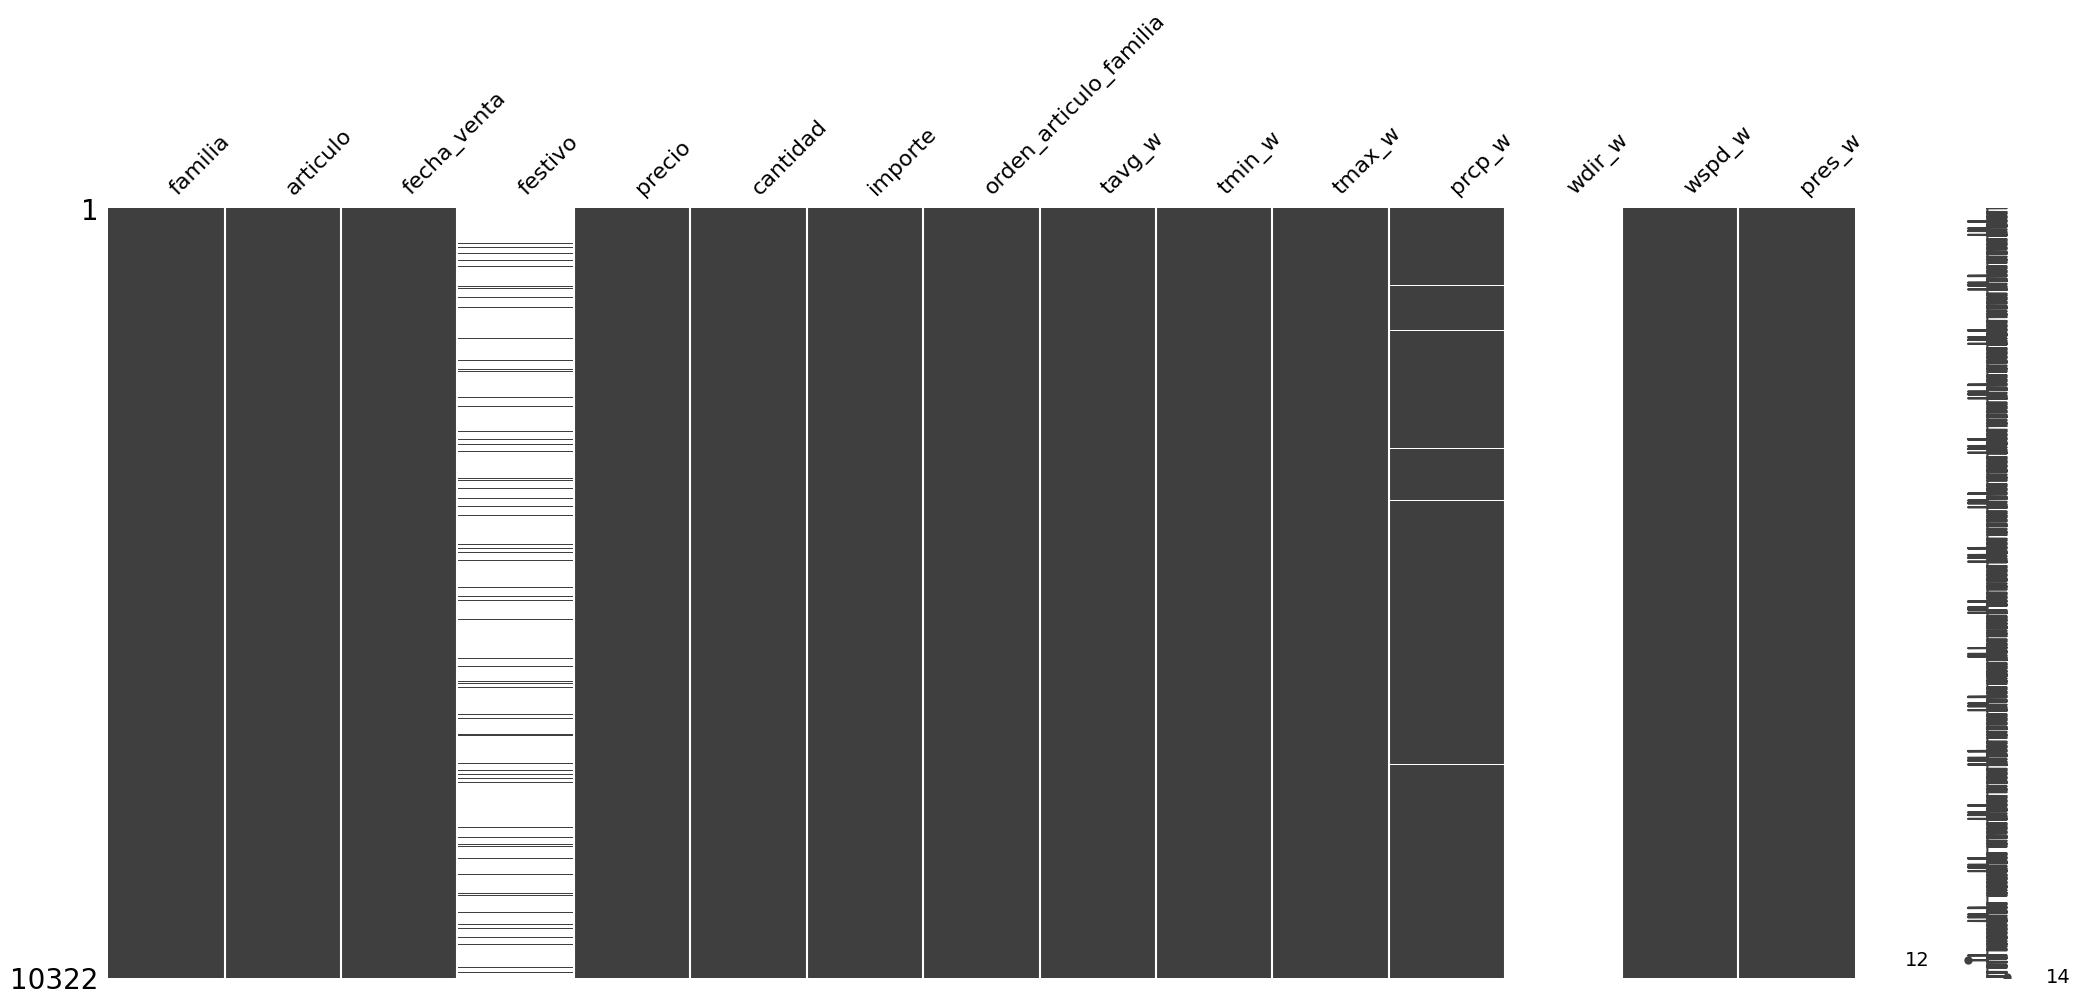

In [16]:
# Gráfico para visualizar dónde hay valores nulos en el DataFrame
msno.matrix(vt)

4. ¿Hay duplicados?

In [17]:
# Filtra filas duplicadas por fecha y artículo
vt[vt.duplicated(['fecha_venta', 'articulo'], keep=False)]

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w


5. ¿Cuál es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¿hay fechas faltantes? Crea un gráfico de evolución temporal para la variable "cantidad" que muestre el producto "6549".

In [18]:
# Rango de fechas de todo el dataset
min_date = vt['fecha_venta'].min()  # Fecha mínima
max_date = vt['fecha_venta'].max()  # Fecha máxima
diferencia = max_date - min_date

print(f"El rango de fecha de los datos contiene valores desde {min_date} hasta {max_date}.\n"
      f"Lo que supone {diferencia}.\n")

# Fechas faltantes por artículo
articulos_unicos = vt.sort_values("familia")["articulo"].unique().tolist()
rango = pd.date_range(start=min_date, end=max_date, freq='D')  # Genera todas las fechas posibles

for article in articulos_unicos:
    subset = vt.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]
    missing_dates = rango.difference(subset['fecha_venta'])
    print(family, "-> Articulo", article, "-> Fechas faltantes", len(missing_dates))

# Gráfico de cantidad vendida de un artículo específico
articulo = 6549
filtered_vt = (
    vt.query("articulo == @articulo")  # Filtramos el artículo
      .set_index("fecha_venta")       # Ponemos la fecha como índice
      .reindex(rango)                 # Reindexamos para incluir fechas faltantes
)

# Completamos las fechas faltantes con el último valor disponible
filtered_vt["articulo"] = filtered_vt["articulo"].fillna(method='ffill')

# Creamos un gráfico de líneas con Plotly mostrando la evolución de la cantidad vendida
fig = px.line(filtered_vt, x=filtered_vt.index, y="cantidad", color="articulo")
fig.show()


El rango de fecha de los datos contiene valores desde 2021-05-01 00:00:00 hasta 2023-04-30 00:00:00.
Lo que supone 729 days 00:00:00.

BOLLERIA -> Articulo 3960 -> Fechas faltantes 0
BOLLERIA -> Articulo 5803 -> Fechas faltantes 3
BOLLERIA -> Articulo 3880 -> Fechas faltantes 0
BOLLERIA -> Articulo 6286 -> Fechas faltantes 2
BOLLERIA -> Articulo 6425 -> Fechas faltantes 1
PANADERIA -> Articulo 1084 -> Fechas faltantes 0
PANADERIA -> Articulo 417 -> Fechas faltantes 0
PANADERIA -> Articulo 900 -> Fechas faltantes 0
PANADERIA -> Articulo 968 -> Fechas faltantes 0
PANADERIA -> Articulo 1043 -> Fechas faltantes 0
PASTELERIA -> Articulo 6451 -> Fechas faltantes 73
PASTELERIA -> Articulo 6549 -> Fechas faltantes 304
PASTELERIA -> Articulo 6523 -> Fechas faltantes 48
PASTELERIA -> Articulo 5403 -> Fechas faltantes 103
PASTELERIA -> Articulo 5404 -> Fechas faltantes 94


6. Separando por producto, ¿hay outliers en la variable "cantidad"?

In [19]:
# Lista de artículos únicos, ordenados por familia
articulos = vt.sort_values("familia")["articulo"].unique().tolist()

for articulo in articulos:
    # Filtramos los datos del artículo actual
    subset = vt.query("articulo == @articulo")
    family = subset["familia"].unique().tolist()[0]

    # Calculamos el rango intercuartílico (IQR) para detectar outliers en cantidad
    Q1 = subset['cantidad'].quantile(0.25)
    Q3 = subset['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    # Identificamos valores atípicos según la regla del IQR
    outliers = subset[(subset['cantidad'] < (Q1 - 1.5 * IQR)) | (subset['cantidad'] > (Q3 + 1.5 * IQR))]

    # Mostramos el número de outliers por artículo
    print(family, "-> Articulo", articulo, "-> Outliers", len(outliers["cantidad"]))


BOLLERIA -> Articulo 3960 -> Outliers 15
BOLLERIA -> Articulo 5803 -> Outliers 52
BOLLERIA -> Articulo 3880 -> Outliers 36
BOLLERIA -> Articulo 6286 -> Outliers 57
BOLLERIA -> Articulo 6425 -> Outliers 25
PANADERIA -> Articulo 1084 -> Outliers 6
PANADERIA -> Articulo 417 -> Outliers 19
PANADERIA -> Articulo 900 -> Outliers 31
PANADERIA -> Articulo 968 -> Outliers 27
PANADERIA -> Articulo 1043 -> Outliers 38
PASTELERIA -> Articulo 6451 -> Outliers 22
PASTELERIA -> Articulo 6549 -> Outliers 3
PASTELERIA -> Articulo 6523 -> Outliers 35
PASTELERIA -> Articulo 5403 -> Outliers 38
PASTELERIA -> Articulo 5404 -> Outliers 25


#### Análisis de la variable a predecir

Se analiza la variable objetivo para entender su distribución, detectar outliers y ver su relación con otras variables, preparando así el terreno para el modelado.

7. Crea un gráfico de la evolución temporal general de la variable "cantidad". 

In [20]:
# Agrupamos las ventas por día y sumamos la cantidad vendida
grupo = vt.groupby(pd.Grouper(key="fecha_venta", freq="1D"))["cantidad"].sum().reset_index()

# Creamos un gráfico de líneas mostrando la evolución diaria de la cantidad vendida
fig = px.line(grupo, x="fecha_venta", y="cantidad")
fig.show()

8. Crea un gráfico de la evolución temporal por familia de la variable "cantidad". 

In [21]:
# Agrupamos las ventas por familia y por día, sumando la cantidad vendida
grupo = vt.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()

# Gráfico de líneas mostrando la evolución diaria de la cantidad vendida por familia
fig = px.line(grupo, x="fecha_venta", y="cantidad", color="familia")
fig.show()

In [22]:
# Inicializamos un scaler para normalizar valores entre 0 y 1
scaler = MinMaxScaler()

# Función para normalizar una columna
def normalize(column):
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

# Agrupamos las ventas por familia y por día, sumando la cantidad
grupo = vt.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()

# Normalizamos la columna 'cantidad' por familia para que cada serie esté entre 0 y 1
grupo['cantidad'] = grupo.groupby('familia')['cantidad'].transform(normalize)

# Gráfico de líneas de cantidad normalizada por familia
fig = px.line(grupo, x="fecha_venta", y="cantidad", color="familia")
fig.show()

9. Crea un gráfico de la evolución temporal por artículo de la variable "cantidad".

In [23]:
# Agrupamos las ventas por artículo y por día, sumando la cantidad vendida
grupo = vt.groupby(["articulo", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()

# Gráfico de líneas mostrando la evolución diaria de la cantidad vendida por artículo
fig = px.line(grupo, x="fecha_venta", y="cantidad", color="articulo")
fig.show()


10. Se que hay mucho ruido, pero ¿a simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

In [24]:

# Calculamos la media móvil de 7 días para suavizar la cantidad de ventas
# Se hace por familia para mantener la tendencia de cada grupo
vt['cantidad_suave'] = vt.groupby('familia')['cantidad'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Creamos un gráfico de líneas de la cantidad suavizada
fig = px.line(vt, x='fecha_venta', y='cantidad_suave', color='familia',
              title='Evolución suavizada de la cantidad por familia (media móvil 7 días)',
              labels={'cantidad_suave': 'Cantidad (suavizada)', 'fecha_venta': 'Fecha'})

# Mostramos el gráfico
fig.show()


11. Aplica alguna técnica estadística para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". 

In [25]:
# Función para verificar si una serie temporal es estacionaria
def check_stationarity(series):
    # Eliminamos NaN y nos aseguramos que los datos sean float
    series = series.dropna().astype(float)
    
    # Test de Dickey-Fuller aumentado
    result = adfuller(series.values)

    # Mostramos los resultados del test
    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Interpretación: estacionaria si p-value <= 0.05 y ADF statistic < critical value 5%
    if (result[1] <= 0.05) and (result[0] < result[4]['5%']):
        print("\u001b[32m Stationary \u001b[0m")  # Texto en verde
    else:
        print("\x1b[31m Non-stationary \x1b[0m")  # Texto en rojo

# Agrupamos las ventas por día sumando la cantidad total
group = vt.groupby(pd.Grouper(key="fecha_venta", freq="1D"))["cantidad"].sum().reset_index()

# Checamos la estacionariedad de la serie diaria
check_stationarity(group["cantidad"])

# Graficamos la serie diaria de cantidad de ventas
fig = px.line(group, x="fecha_venta", y="cantidad", title="Serie diaria de cantidad")
fig.show()

ADF Statistic:  -1.463925551689556
p-value:  0.5512754432670588
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Non-stationary 


In [26]:
# Calculamos la primera diferencia de la serie para intentar hacerla estacionaria
group["cantidad_diff"] = group["cantidad"].diff().fillna(0)

# Verificamos si la serie diferenciada es estacionaria
check_stationarity(group["cantidad_diff"])


ADF Statistic:  -12.370069833226818
p-value:  5.305870454948056e-23
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Stationary 


In [27]:
# El gráfico de la nueva serie al convertirse en estacionario.
fig = px.line(group, x="fecha_venta", y="cantidad_diff")
fig.show()

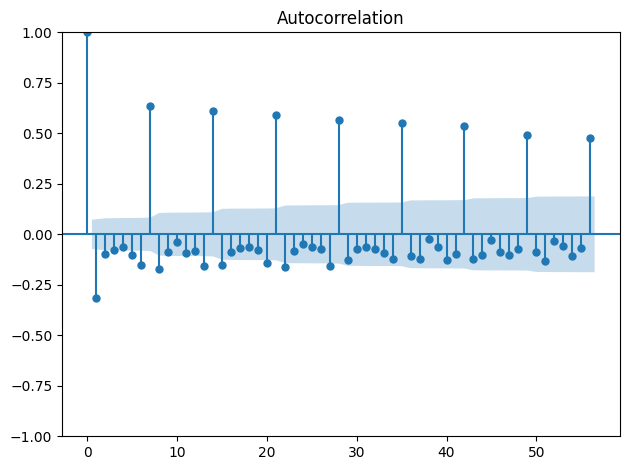

In [28]:
# Análisis de autocorrelación de la serie diferenciada
plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

#### Análisis de la variable a predecir frente al resto de variables

Se examina cómo la variable objetivo se relaciona con las demás variables, identificando patrones, correlaciones o dependencias que puedan ser útiles para predecirla.

12. ¿El comportamiento de compra (la variable "cantidad") cuando es festivo es superior a cuando no lo es?



In [29]:
# Creamos una columna binaria: 1 si es festivo, 0 si no lo es
vt['es_festivo'] = vt['festivo'].apply(lambda x: 0 if x is None else 1)

# Boxplot de cantidad vendida según si es festivo o no, diferenciado por familia
fig = px.box(vt, x="es_festivo", y="cantidad", color='familia')
fig.show()

# Insight: durante los festivos, la cantidad vendida suele aumentar ligeramente

13. ¿El comportamiento de compra (la variable "cantidad") cuando llueve es superior a cuando no llueve?

In [30]:
# Creamos una columna binaria: 1 si hubo lluvia, 0 si no
vt["lluvia"] = np.where(vt["prcp_w"].fillna(0) > 0, 1, 0)

# Boxplot de cantidad vendida según si llovió o no, diferenciado por familia
fig = px.box(vt, x="lluvia", y="cantidad", color='familia')
fig.show()

# Insight: las compras parecen mantenerse aunque llueva


14. Divide la variable "tavg_w" en quintiles y muestra con un gráfico de barras sí la variable "cantidad" es superior en alguno de sus quintiles.

In [31]:
# Etiquetas para clasificar la temperatura media en 5 quintiles
labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

# Creamos una columna con quintiles de temperatura media diaria
vt['quintiles_tavg_w'] = pd.qcut(vt['tavg_w'], q=5, labels=labels_tavg)

# Agrupamos por familia y quintil de temperatura, sumando la cantidad vendida
group = vt.groupby(["familia", "quintiles_tavg_w"])["cantidad"].sum().reset_index()

# Gráfico de barras mostrando la cantidad vendida por quintil de temperatura y familia
fig = px.bar(group, x='quintiles_tavg_w', y='cantidad', color="familia", barmode='group')
fig.show()


/tmp/ipykernel_19361/547047157.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



15. ¿Hay correlaciones entre variables meteorológicas (temperatura, precipitación, presión) y la cantidad vendida?

In [32]:
# Aseguramos que 'fecha_venta' sea tipo datetime
vt['fecha_venta'] = pd.to_datetime(vt['fecha_venta'])

# Extraemos el día de la semana (0 = lunes, 6 = domingo)
vt['dia_semana'] = vt['fecha_venta'].dt.dayofweek

# Opcional: convertimos a nombre del día para mejor lectura
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
vt['nombre_dia'] = vt['dia_semana'].apply(lambda x: dias[x])

# Calculamos el promedio de cantidad vendida por día de la semana
ventas_por_dia = vt.groupby('nombre_dia')['cantidad'].mean().reindex(dias)

# Gráfico de barras del promedio de ventas por día de la semana
fig = px.bar(
    ventas_por_dia,
    x=ventas_por_dia.index,
    y='cantidad', 
    labels={'x':'Día de la semana', 'cantidad':'Promedio cantidad vendida'},
    title='Promedio de cantidad vendida por día de la semana'
)
fig.show()

16. ¿Cuáles son los productos o familias con mayor variabilidad en las ventas?

In [33]:
# Calculamos la desviación estándar de la cantidad vendida por familia
variabilidad_familia = vt.groupby('familia')['cantidad'].std().reset_index()
variabilidad_familia = variabilidad_familia.rename(columns={'cantidad': 'std_cantidad'})
variabilidad_familia = variabilidad_familia.sort_values(by='std_cantidad', ascending=False)

# Seleccionamos las 20 familias con mayor variabilidad
top_variabilidad = variabilidad_familia.head(20)

# Gráfico de barras mostrando la desviación estándar por familia
fig = px.bar(
    top_variabilidad, 
    x='familia', 
    y='std_cantidad', 
    title='Variabilidad de ventas por familias',
    labels={'std_cantidad': 'Desviación estándar de cantidad', 'familia': 'Familia'}
)
fig.show()


17. ¿Qué día del mes se vende más?

In [34]:
# Extraemos el día del mes de la fecha de venta
vt['dia_mes'] = vt['fecha_venta'].dt.day

# Sumamos la cantidad vendida por cada día del mes
ventas_por_dia_mes = vt.groupby('dia_mes', as_index=False)['cantidad'].sum()

# Identificamos el día del mes con mayor venta
dia_max = ventas_por_dia_mes.loc[ventas_por_dia_mes['cantidad'].idxmax(), 'dia_mes']

# Creamos columna para resaltar el día con mayor venta
ventas_por_dia_mes['destacado'] = ventas_por_dia_mes['dia_mes'].apply(
    lambda x: 'Mayor venta' if x == dia_max else 'Otros días'
)

# Gráfico de barras resaltando el día con mayor venta
fig = px.bar(
    ventas_por_dia_mes, 
    x='dia_mes', 
    y='cantidad', 
    color='destacado',
    color_discrete_map={'Mayor venta': 'crimson', 'Otros días': 'lightblue'},
    title='Ventas totales por día del mes (resaltando día con mayor venta)',
    labels={'dia_mes': 'Día del mes', 'cantidad': 'Cantidad vendida'}
)

fig.show()

18. ¿Qué día del año se vendió más?

In [35]:
# 1. Preparar datos
# Extraemos año y día del mes
vt['anio'] = vt['fecha_venta'].dt.year
vt['dia_mes'] = vt['fecha_venta'].dt.day

# Sumamos cantidad vendida por año y día
ventas_por_dia = vt.groupby(['anio', 'dia_mes', 'fecha_venta'], as_index=False)['cantidad'].sum()

# Identificamos el día con mayor venta de cada año
max_ventas = ventas_por_dia.loc[ventas_por_dia.groupby('anio')['cantidad'].idxmax()]
max_ventas['fecha_str'] = max_ventas['fecha_venta'].dt.strftime('%Y-%m-%d')

# 2. Graficar
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=max_ventas['anio'],
    y=max_ventas['cantidad'],
    mode='lines+markers+text',  # Línea con marcadores y etiquetas
    text=max_ventas['fecha_str'],  # Mostrar fecha exacta sobre el punto
    textposition='top center',
    name='Ventas máximas por día'
))

fig.update_layout(
    title='Día con mayor venta total por año',
    xaxis_title='Año',
    yaxis_title='Cantidad máxima vendida',
    yaxis=dict(rangemode='tozero')
)

fig.show()


19. ¿Cuáles son los productos que tienen mayor número de días sin ventas?

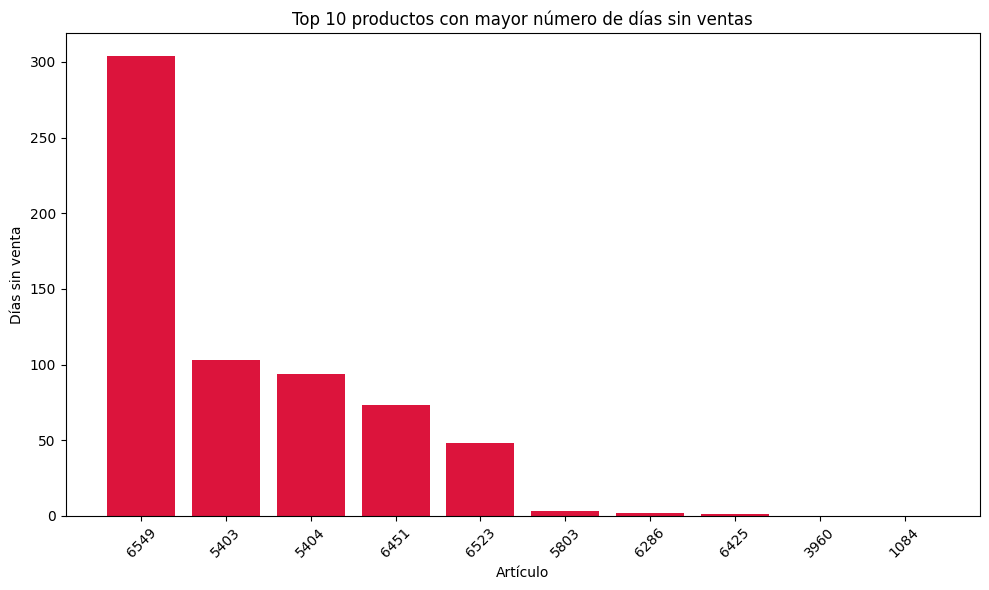

In [36]:
# Aseguramos que 'fecha_venta' sea datetime
vt['fecha_venta'] = pd.to_datetime(vt['fecha_venta'])

# Generamos rango completo de fechas
fechas_completas = pd.date_range(start=vt['fecha_venta'].min(), end=vt['fecha_venta'].max())

# Lista de productos únicos
productos = vt['articulo'].unique()

# Calculamos los días sin venta por producto
dias_sin_venta = []
for prod in productos:
    vt_prod = vt[vt['articulo'] == prod]
    fechas_con_ventas = vt_prod.loc[vt_prod['cantidad'] > 0, 'fecha_venta'].drop_duplicates()
    dias_sin = len(fechas_completas.difference(fechas_con_ventas))
    dias_sin_venta.append({'articulo': prod, 'dias_sin_venta': dias_sin})

df_dias_sin_venta = pd.DataFrame(dias_sin_venta).sort_values(by='dias_sin_venta', ascending=False)

# Graficamos los 10 productos con más días sin venta
if not df_dias_sin_venta.empty:
    top10 = df_dias_sin_venta.head(10)
    plt.figure(figsize=(10,6))
    plt.bar(top10['articulo'].astype(str), top10['dias_sin_venta'], color='crimson')
    plt.xticks(rotation=45)
    plt.title('Top 10 productos con mayor número de días sin ventas')
    plt.xlabel('Artículo')
    plt.ylabel('Días sin venta')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos para mostrar.")
